In [162]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import asarray
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from sklearn import preprocessing
import datetime
import time
import math

In [163]:
if torch.cuda.is_available(): 
    dev = "cuda:0" 
else: 
    dev = "cpu" 
device = torch.device(dev)
dev

'cuda:0'

In [164]:
df = pd.read_csv('Dataset/J-17.csv')
# set datetime as index
df.index = pd.to_datetime(df['DailyHighDate'].astype(str))
# resort by datetime
df.sort_index(axis=0,ascending=True)

,Site,DailyHighDate,WaterLevelElevation
DailyHighDate,,,
1932-11-12,J17WL,1932-11-12,675.60
1932-11-13,J17WL,1932-11-13,675.82
1932-11-14,J17WL,1932-11-14,675.97
1932-11-15,J17WL,1932-11-15,675.92
1932-11-16,J17WL,1932-11-16,675.74
...,...,...,...
2023-02-26,J17WL,2023-02-26,637.31
2023-02-27,J17WL,2023-02-27,636.80
2023-02-28,J17WL,2023-02-28,636.29


In [165]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return asarray(X), asarray(y)

In [166]:
value = df.drop(['Site','DailyHighDate'], axis=1).astype('float32')
min_max_scaler = preprocessing.MinMaxScaler()
value = min_max_scaler.fit_transform(value)
value

array([[0.2537446 ],
       [0.25848007],
       [0.26189423],
       ...,
       [0.6988983 ],
       [0.697247  ],
       [0.69482374]], dtype=float32)

In [167]:
# specify the window size
n_steps = 7
# split into samples
X, y = split_sequence(value, n_steps)

In [168]:
# reshape into [samples, timesteps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))
# split into train/test
n_test = 320
X_train, X_test, y_train, y_test = X[:-n_test], X[-n_test:], y[:-n_test], y[-n_test:]
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(31855, 7, 1) (320, 7, 1) (31855, 1) (320, 1)


In [169]:
X_train[:3]

array([[[0.2537446 ],
        [0.25848007],
        [0.26189423],
        [0.2675109 ],
        [0.27312803],
        [0.2683921 ],
        [0.26652002]],

       [[0.25848007],
        [0.26189423],
        [0.2675109 ],
        [0.27312803],
        [0.2683921 ],
        [0.26652002],
        [0.26861286]],

       [[0.26189423],
        [0.2675109 ],
        [0.27312803],
        [0.2683921 ],
        [0.26652002],
        [0.26861286],
        [0.2716961 ]]], dtype=float32)

In [170]:
y_train[:3]

array([[0.26861286],
       [0.2716961 ],
       [0.27202702]], dtype=float32)

In [171]:
X_train = torch.tensor(X_train).to(device)
y_train = torch.tensor(y_train).to(device)
X_test = torch.tensor(X_test).to(device)
y_test = torch.tensor(y_test).to(device)

In [172]:
print(X_train.size())
print(X_test.size())
print(y_train.size())
print(y_test.size())

torch.Size([31855, 7, 1])
torch.Size([320, 7, 1])
torch.Size([31855, 1])
torch.Size([320, 1])


RNN built-in layers such as nn.GRU and nn.LSTM return a tuple of tensors.
Error: relu(): argument 'input' (position 1) must be Tensor, not tuple.

For this reason you can't have this type of layer in a nn.Sequential pipeline. 

In [190]:
'''
model = nn.Sequential(
    nn.LSTM(input_size=1, hidden_size=100, num_layers=1, batch_first=True),
    nn.ReLU(),
    nn.Linear(100, 50),
    nn.ReLU(),
    nn.Linear(50, 1),
).to(device)

RNN built-in layers such as nn.GRU and nn.LSTM return a tuple of tensors.
Error: relu(): argument 'input' (position 1) must be Tensor, not tuple.
For this reason we can't have this type of layer in a nn.Sequential pipeline. 
Need to build a custom module to combine the recurrent neural network with the fully connected layer
'''
from torch.autograd import Variable
class LSTMmodel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=100, num_layers=1, batch_first=True)
        self.fc = nn.Sequential(nn.ReLU(),
                                nn.Linear(100, 50), 
                                nn.ReLU(),
                                nn.Linear(50, 1))
    def forward(self, x):
        h_0 = Variable(torch.zeros(1, len(x), 100).cuda())
        c_0 = Variable(torch.zeros(1, len(x), 100).cuda())
        output, (final_hidden_state, final_cell_state) = self.lstm(x, (h_0, c_0))
        out = self.fc(final_hidden_state[-1]) 
        return out
    
model = LSTMmodel().to(device)
optimizer = optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train, y_train), shuffle=False, batch_size=64)

In [191]:
n_epochs = 60
time_list = []
train_loss_list = []
for epoch in range(n_epochs):
    train_loss = []
    model.train()
    start_time = time.time()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        if epoch == 0:
            print('X_batch', X_batch.size())
            print(y_pred.size())
            print('y_batch', y_batch.size())
        loss = loss_fn(y_pred, y_batch)
        train_loss.append(float(loss.data.mean()))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss_list.append(np.mean(train_loss))
    total_time = time.time() - start_time
    time_list.append(total_time)

X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y

X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y

X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y_batch torch.Size([64, 1])
X_batch torch.Size([64, 7, 1])
torch.Size([64, 1])
y

In [192]:
print('Final MSE for training set:', train_loss_list[-1])

Final MSE for training set: 5.4659997857355386e-05


Total training time: 57.09863781929016
Average training time: 0.9516439636548361


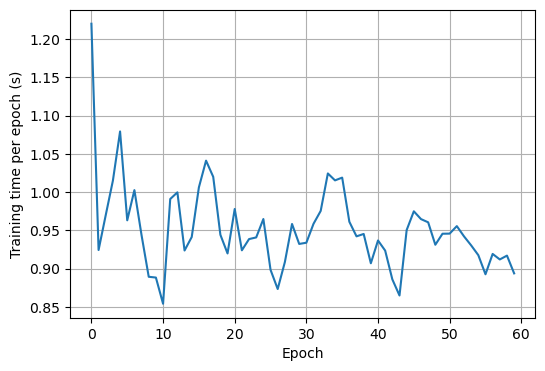

In [193]:
x = np.linspace(0.0, n_epochs-1, n_epochs)

print('Total training time:', sum(time_list))
print('Average training time:', sum(time_list)/n_epochs)
plt.figure(figsize=(6,4))
plt.xlabel('Epoch')
plt.ylabel('Training time per epoch (s)')
plt.plot(x, time_list)
plt.grid()

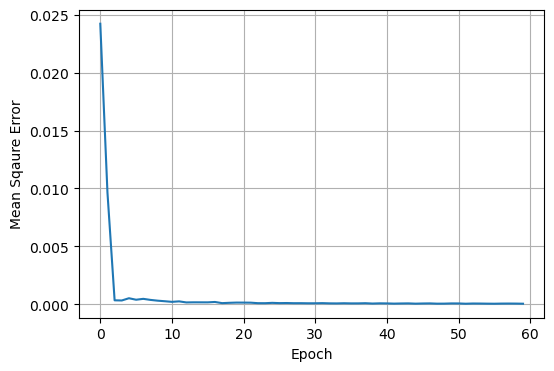

In [194]:
x = np.linspace(0.0, n_epochs-1, n_epochs)

plt.figure(figsize=(6,4))
plt.xlabel('Epoch')
plt.ylabel('Mean Sqaure Error')
plt.plot(x, train_loss_list)
plt.grid()

In [195]:
# evaluate trained model with test set
model = model.eval()
y_pred = model(X_test)
print(X_test.size())
print(y_pred.size())
print(y_test.size())
test_mse = loss_fn(y_pred, y_test)
print('RMSE for test set:', math.sqrt(test_mse))

torch.Size([320, 7, 1])
torch.Size([320, 1])
torch.Size([320, 1])
RMSE for test set: 0.002445585150085767


In [196]:
# evaluate trained model with test set
model = model.eval()
y_pred_train = model(X_train)
print(X_train.size())
print(y_pred_train.size())
train_mse = loss_fn(y_pred_train, y_train)
print('RMSE for train set:', math.sqrt(train_mse))

torch.Size([31855, 7, 1])
torch.Size([31855, 1])
RMSE for train set: 0.005767704631978346


In [197]:
# inverse transformation
#y_pred_real = min_max_scaler.inverse_transform(y_pred)
#y_test_real = min_max_scaler.inverse_transform(y_test)
# Error: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.
y_pred1 = torch.Tensor.cpu(y_pred)
y_test1 = torch.Tensor.cpu(y_test)
# Error: Can't call numpy() on Tensor that requires grad. Use tensor.detach().numpy() instead.
y_pred2 = y_pred1.detach().numpy()
y_test2 = y_test1.detach().numpy()
print(np.shape(y_pred2))
print(np.shape(y_test2))

(320, 1)
(320, 1)


In [198]:
y_pred_real = min_max_scaler.inverse_transform(y_pred2)
y_test_real = min_max_scaler.inverse_transform(y_test2)
y_pred_real[:5]

array([[672.44653],
       [672.46466],
       [672.6266 ],
       [672.3019 ],
       [672.2285 ]], dtype=float32)

In [199]:
y_test_real[:5]

array([[672.38],
       [672.5 ],
       [672.3 ],
       [672.2 ],
       [672.1 ]], dtype=float32)

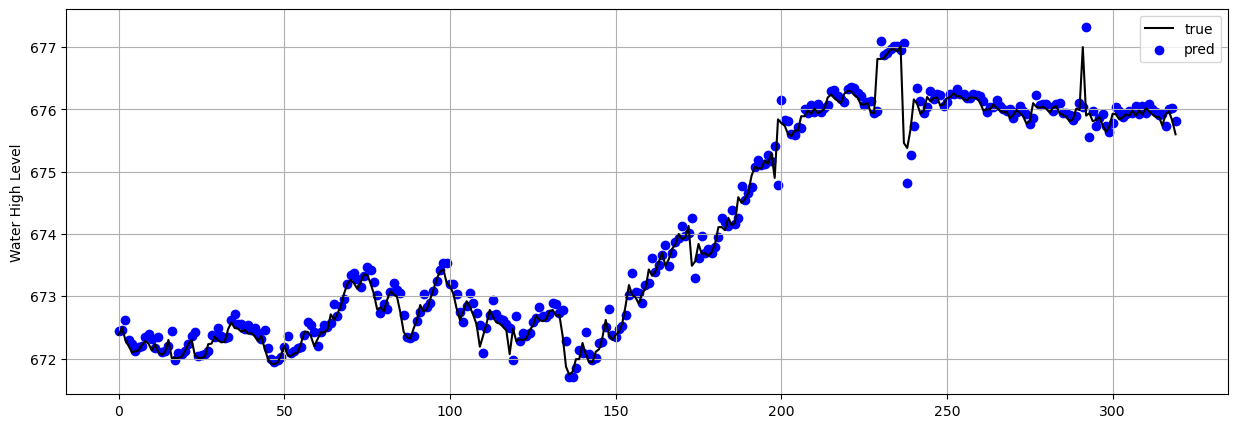

In [200]:
x = np.linspace(0.0, len(y_test)-1, len(y_test))
plt.figure(figsize=(15,5))
plt.plot(x, y_test_real, label='true', color='black')
plt.scatter(x, y_pred_real, label='pred', color='blue')
plt.ylabel('Water High Level')
plt.grid()
plt.legend()
plt.show()

In [184]:
mse = loss_fn(torch.tensor(y_pred_real), torch.tensor(y_test_real))
print('RMSE for test set without scaling:', math.sqrt(mse))

RMSE for test set without scaling: 0.22758610284181274
